In [1]:
from qiskit.algorithms.linear_solvers.vqls import VQLS
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit import Aer
import numpy as np


In [2]:
A = np.random.rand(4,4)
A = np.arange(16).reshape(4,4)
A = (A+A.T)/10

b = np.arange(4)/10

In [3]:
backend = Aer.get_backend('aer_simulator')
ansatz = RealAmplitudes(2, entanglement='linear', reps=2, insert_barriers=False)
vqls  = VQLS(
    ansatz=ansatz,
    quantum_instance=backend
)


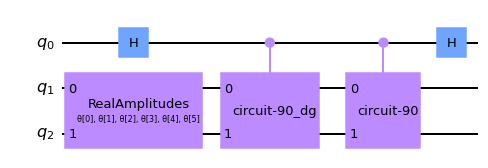

In [4]:
circuits = vqls.construct_circuit(A,b)
circuits[0].draw('mpl')

In [8]:
num_parameters = vqls.ansatz.num_parameters 
parameters = np.arange(num_parameters)/10
ansatz_params = vqls.ansatz.parameters
param_bindings = dict(zip(ansatz_params, parameters))

In [9]:
ansatz_params = vqls.ansatz.parameters
vqls.num_qubits = 2
vqls.construct_observalbe() 
expect_ops = []
for circ in circuits:
    expect_ops.append(vqls.construct_expectation(ansatz_params, circ))

In [10]:
parameter_sets = np.reshape(parameters, (-1, num_parameters))
param_bindings = dict(zip(ansatz_params, parameter_sets.transpose().tolist()))  

probabiliy_circuit_output = []
for op in expect_ops:
    sampled_expect_op = vqls._circuit_sampler.convert(op, params=param_bindings)  
    probabiliy_circuit_output.append(vqls.get_probability_from_expected_value(sampled_expect_op.eval()[0]))
print(probabiliy_circuit_output)

[(0.884765625+0j), (0.876953125+0j), (0.373046875+0j), (0.26953125+0j), (0.853515625+0j), (0.876953125+0j), (0.462890625+0j), (0.40625+0j), (0.419921875+0j), (0.400390625+0j)]


In [49]:
sum_coeff = []
for ii in range(len(vqls.matrix_circuits)):
    ci = vqls.matrix_circuits[ii].coeff
    for jj in range(ii+1,len(vqls.matrix_circuits)):
        cj = vqls.matrix_circuits[jj].coeff
        sum_coeff.append(ci.conj()*cj)
sum_coeff = np.array(sum_coeff)

vqls._compute_phi_overlap(sum_coeff, probabiliy_circuit_output)

(-0.0341796875+0j)

# Extract the state vector of the measurement circuit

In [9]:
from qiskit import transpile, assemble

num_parameters = vqls.ansatz.num_parameters 
parameters = np.arange(num_parameters)/10
circuit = circuits[0].assign_parameters(parameters)

circuit.save_statevector()
t_circ = transpile(circuit, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)
result = job.result()
state_vector = result.get_statevector(circuit,decimals=16)
state_vector

Simulation failed and returned the following error message:
ERROR: Failed to load qobj: Duplicate key "statevector" in save instruction.


QiskitError: 'Data for experiment "circuit-829" could not be found.'

In [25]:
out = vqls.get_probability_from_statevector(state_vector)
print(out)

(-0.5079022988026467+0j)


# Extract the expected value of the circuit

In [26]:
backend = Aer.get_backend('aer_simulator')
backend.options.shots = 10000
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [35]:
from qiskit.opflow import (
    Z,
    I,
    StateFn,
    OperatorBase,
    TensoredOp,
    ExpectationBase,
    CircuitSampler,
    ListOp,
    ExpectationFactory,
)
from qiskit.utils import QuantumInstance
from qiskit.opflow.state_fns.circuit_state_fn import CircuitStateFn

one_op = (I - Z) / 2
zero_op = (I + Z) / 2
observable =  TensoredOp(2*[I]) ^ one_op

exp = ~StateFn(observable) @ StateFn(circuit)


quantum_instance = QuantumInstance(backend)
sampler = CircuitSampler(quantum_instance)

exp_ = sampler.convert(exp).eval()
print(exp_)
print(1-2*exp_)


(0.7514+0j)
(-0.5027999999999999+0j)


In [33]:
np.conjugate(np.array(state_vector)) @ observable.to_matrix() @ np.array(state_vector)

(0.7539511494013234+0j)